<a href="https://colab.research.google.com/github/pikey-msc/AprendizMaquina/blob/main/2023-1/AprendizMaquina/Ensambles/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBOOST



**¿Qué es Gradient Boost y XGBoost?**

Gradient Boosting es un tipo de método de conjunto, muy parecido a Bagging. Sin embargo, Boosting difiere de los métodos mencionados anteriormente en relación con la forma en que hace tal combinación de modelos. Utiliza técnicas para combinar varios estudiantes débiles en un aprendiz fuerte.

Mientras que los otros métodos de conjunto se basan en la construcción simultánea de varios aprendices de base aislados que luego se utilizan para hacer la predicción, los algoritmos de refuerzo se basan en un proceso secuencial, en el que cada modelo intenta corregir los errores de los modelos anteriores. Esto conduce a un gran inconveniente de eficiencia, ya que los modelos se crean uno a la vez y dependen de los resultados obtenidos en las iteraciones anteriores.

Gradient Boosting emplea el algoritmo gradiente descendente para minimizar los errores en los modelos secuenciales, por lo que, en esencia, es un problema de optimización donde el objetivo es minimizar el error (pérdida) funcional.

XGBoost (eXtreme Gradient Boosting), a su vez, es una implementación optimizada del algoritmo Gradient Boosting. Incluye (entre otras mejoras): construcción de árboles paralelos, acceso con reconocimiento de caché, reconocimiento de escasez, regularización (tanto L1 como L2), ponderación bosquejo cuantil. La biblioteca se ha convertido en una de las soluciones de acceso para ganar muchas competencias de ciencia de datos en los últimos años.

Algunos de los hiperparámetros de XGBoost

Los hiperparámetros de XGBoost fueron divididos en 3 categorías por los autores originales:

*	**Parámetros generales**: hiperparámetros que controlan el funcionamiento general del algoritmo;
*	**Parámetros de refuerzo:** hiperparámetros que controlan los impulsores individuales (árbol o regresión) en cada paso del algoritmo;
*	**Learning Task Parameters:** hiperparámetros que configuran la optimización a realizar;

Una de las mayores ventajas de XGBoost es la cantidad de personalización disponible. Para consultar la lista completa de hiperparámetros disponibles (es bastante extensa), le recomiendo que consulte la página de documentación del proyecto.

XGBoost proporciona una API compatible con scikit-learn y algunos parámetros tienen nombres ligeramente diferentes, pero funcionan igual que en la API de la biblioteca normal.

Estos son algunos de los hiperparámetros que ajustaremos en nuestro caso de estudio para comprenderlos mejor:

* **booster:** nos permite elegir cada booster a utilizar: gbtree, para modelos basados en árbol, o gblinear, para modelos lineales.
* **objetivo:** forma parte de los hiperparámetros de la Tarea de aprendizaje y especifica la tarea de aprendizaje (regresión, clasificación, ranking, etc.) y la función que se utilizará en el proceso de optimización.
*	**tree_method**: usaremos la opción “gpu_exact” para ejecutar en la GPU
*	**eval_metric**: la métrica utilizada para evaluar el rendimiento de los datos de entrenamiento. Podemos pasar múltiples métricas en el formato de una lista de python y, por lo tanto, usaremos "error" (el error de clasificación binaria) y "auc" en el caso de estudio.
*	**learning_rate (eta)**: escala los pesos recién agregados después de cada paso del impulso del árbol. Esta técnica se llama “shrinkage” y se encarga de reducir la influencia de cada árbol individual, dejando espacio para que futuros árboles mejoren el modelo. En general, se encuentra que las tasas de aprendizaje inferiores a 0,1 producen mejores errores de generalización.
*	**gamma**: un nodo de árbol se divide cuando la división resultante genera una reducción positiva de la función de pérdida. El parámetro gamma especifica la reducción mínima requerida para realizar dichas divisiones. Su valor depende de la función de pérdida que se utilice.
*	**max_ depth**: limita la profundidad máxima a la que los árboles pueden crecer. Los árboles más grandes son propensos al sobreajuste.
*	**colsample_bytree**: establece la fracción de características (columnas del conjunto de datos) que se usarán aleatoriamente al ajustar cada árbol individual.
*	**submuestra**: establece la fracción de observaciones (filas del conjunto de datos) que se usarán aleatoriamente al ajustar cada árbol individual.
*	**reg_alpha**: controla la regularización de L1. Dado que la regularización de L1 tiende a llevar los pesos a cero, es más recomendable cuando se usan impulsores lineales o datos con alta dimensionalidad.
*	**reg_lambda**: controla la regularización de L2. Dado que la regularización L2 fomenta pesos más bajos (pero no necesariamente 0), se puede usar para potenciadores de árboles.
*	**n_estimators**: el número de árboles para encajar

Como puede ver, hay múltiples hiperparámetros para ajustar, y los presentados arriba ni siquiera están cerca de la totalidad.

Evaluación del rendimiento de XGBoost

Primero, vamos a ajustar un clasificador XGBoost listo para usar para obtener una comprensión básica del rendimiento del modelo, lo que significa que no vamos a ajustar la mayoría de los parámetros del modelo.

La biblioteca XGBoost implementa dos API principales para el entrenamiento de modelos: la API de aprendizaje predeterminada, que brinda un control más preciso sobre el modelo; y la API de Scikit-Learn, un contenedor de scikit-learn que nos permite usar el modelo XGBoost junto con objetos de scikit-learn como Pipelines y RandomizedSearchCV.

Por ahora, nos centraremos principalmente en la API Scikit-Learn. Esta API proporciona un método para evaluar la variación del rendimiento del modelo con la adición incremental de nuevos árboles. Para hacerlo, debemos proporcionar los siguientes argumentos adicionales al método de ajuste: eval_set, los conjuntos de evaluación que se usarán (generalmente los conjuntos de entrenamiento y prueba), y eval_metric, las métricas que se usarán al realizar la evaluación. Si se proporcionan estos dos argumentos, los resultados de la evaluación estarán disponibles mediante el atributo eval_results del modelo ajustado.


Se cargará el conjunto de datos, lo transformamos en la matriz de características X y el vector de destino y, realizamos los pasos de preprocesamiento y, finalmente, dividimos los datos en conjuntos de entrenamiento y prueba. Este proceso se destaca en el siguiente código:



In [2]:
!rm -rf AprendizMaquina
!git clone https://github.com/pikey-msc/AprendizMaquina


import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import BaggingClassifier

Cloning into 'AprendizMaquina'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 361 (delta 5), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (361/361), 41.21 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [3]:
# load the dataset
income = pd.read_csv("/content/AprendizMaquina/2023-1/Ensambles/census.csv")
income.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Feature Engineering

In [4]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!='United-States'] = 'non_usa'
            df.loc[df['native-country']=='United-States'] = 'usa'
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        return df

In [5]:
# Create the X feature matrix and the y target vector
X = income.drop(columns=["class", 'fnlwgt'], axis=1)
y = income["class"]

# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(y)
y = pd.Series(col.codes)
# validate the preprocessing pipeline by passing data through it
seed=108

In [6]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()
# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]
# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),
]
# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

In [7]:
pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [8]:
clean_X = preprocessing_pipeline.fit_transform(X)
clean_X_df = pd.DataFrame(clean_X, columns=X.columns)
# split the clean_X into train and test sets
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)


Con esto, se puede entrenar el modelo XGBoost, se utilizarán el hiperparámetro "n_estimators" a 500. 

In [9]:
import time
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=500, random_state=seed)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 7.2 s, sys: 605 ms, total: 7.8 s
Wall time: 8.11 s


XGBClassifier(n_estimators=500, random_state=108)

El entrenamiento duró 11.4 segundos por loq ue es un muy buen comienzo.

El comportamiento del modelo es:



In [10]:
# final model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8500460687960688
Test Accuraccy:  0.8435436818670352
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4945
           1       0.78      0.48      0.60      1568

    accuracy                           0.84      6513
   macro avg       0.82      0.72      0.75      6513
weighted avg       0.84      0.84      0.83      6513



El modelo por defecto da una buena precisión, ¿cómo se mejora incrementando estimadores?

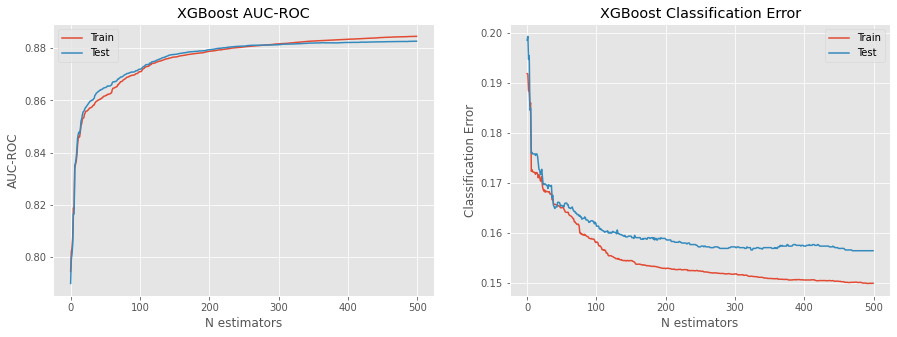

<Figure size 432x288 with 0 Axes>

In [11]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

Se nota que el modelo se mejora hasta los 300 estimadores y a partir de ahí de ahí se estabiliza, aunque meter más estimadores pueda acarrear sobreestimación, para evitar esto se puede usar el hiperparámetro ``early_stopping_rounds``

## Ajuste de hiperparámetros con ``RandomizedSearchCV``


Qué pasa si requiere iterar 7 hiperparámetros y probar 3 valores distintos en cada uno de ellos. Si se hace manualmente o con un grid ingenuo, se harán $3^7=2187$ modelos distintos, que tardaría por modelo 11.2 segundos lo que implica unas 6.8 horas en todo.

Al usar ``RandomizedSearchCV`` se configura el espacio a buscar donde los hiperparámetros que se pueden iterar son learning_rate, colsample_bytree, subsample, max_depth, n_estimatros, reg_lambda, y gamma. 

Un ejemplo es:

In [12]:
# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6,  1.0],
    "subsample": [0.6,  1.0],
    "max_depth": [2,  4],
    "n_estimators": [ 300, 450],
    "reg_lambda": [1,  2],
    "gamma": [0, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=25
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

CPU times: user 6.3 s, sys: 615 ms, total: 6.91 s
Wall time: 9min 38s


El tiempo fue de xxx, hay que ver el desempeño:

In [13]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.8756870289093126
Best model: {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}


Viendo el comportamiento en predicciones:

In [14]:
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.8503148034398035
Test Accuraccy:  0.8427759864885613

Confusion Matrix:
[[4733  212]
 [ 812  756]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4945
           1       0.78      0.48      0.60      1568

    accuracy                           0.84      6513
   macro avg       0.82      0.72      0.75      6513
weighted avg       0.84      0.84      0.83      6513



Se observa una mejora pero no mucha para ser honestos.

## Usando la potencia del GPU de Colab

¿Cómo se configura el colab para usar el GPU?
Sólo hay que seleccionar en editar / configuración de cuaderno, y seleccionar el GPU y dar guardar. 

Desde el código sólo se cambia el hiperparámetro de ``tree_method`` todo lo demás queda igual.

In [15]:
model = XGBClassifier(
    tree_method = "gpu_hist", 
    random_state=seed, 
    eval_metric=["error", "auc"]
)

%time best_model_gpu = grid.fit(X_train,y_train)

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

CPU times: user 6.51 s, sys: 547 ms, total: 7.05 s
Wall time: 10min 11s
Best score: 0.8762798481701953
Best model: {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 450, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Train Accuracy:  0.8495853808353808
Test Accuraccy:  0.8441578381698143

Confusion Matrix:
[[4729  216]
 [ 799  769]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      4945
           1       0.78      0.49      0.60      1568

    accuracy                           0.84      6513
   macro avg       0.82      0.72      0.75      6513
weighted avg       0.84      0.84      0.83      6513



## Interpretabilidad del modelo

Las herramientas que apoyan a la interpretabilidad son ELI5 y SHAP.

Sin embargo, la librería de XGBoost provee gráficas para la importancia de las variables y una representación de árboles utilizados en el "boosting".

Parar graficar la importancia se usa el método ``plot_importances``. Es posible especificar una de las tres métricas para calcular el puntaje de las variables individualmente:

* Feature Weights: El puntaje se calcula basado en el número de veces que la variable aparece en los árboles.

* Gain: El puntaje es calculado basándose en el promedio de ganancia de las separaciones o bifurcaciones usadas en la variable.

Ejemplo:

In [22]:
import time
from xgboost import XGBClassifier, plot_importance, plot_tree

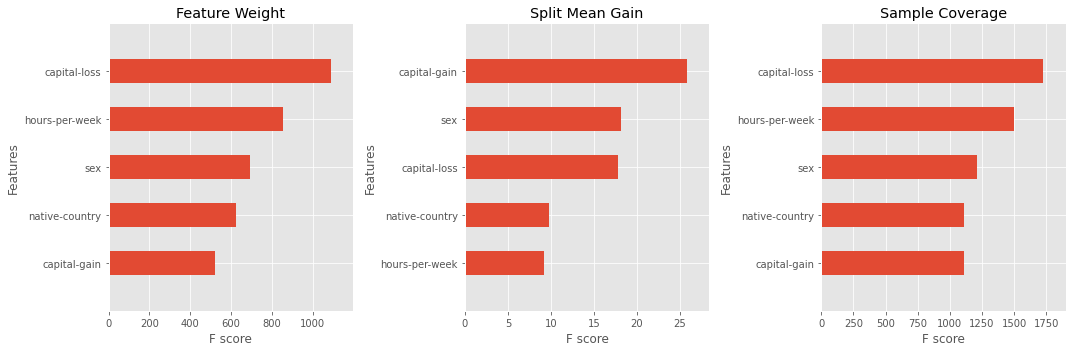

In [21]:
# store the winning model in a new variable
xgc = best_model_gpu.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

Y, finalmente, para graficar un árbol en específico, se usa el método ``plot_tree`` como se muestra:

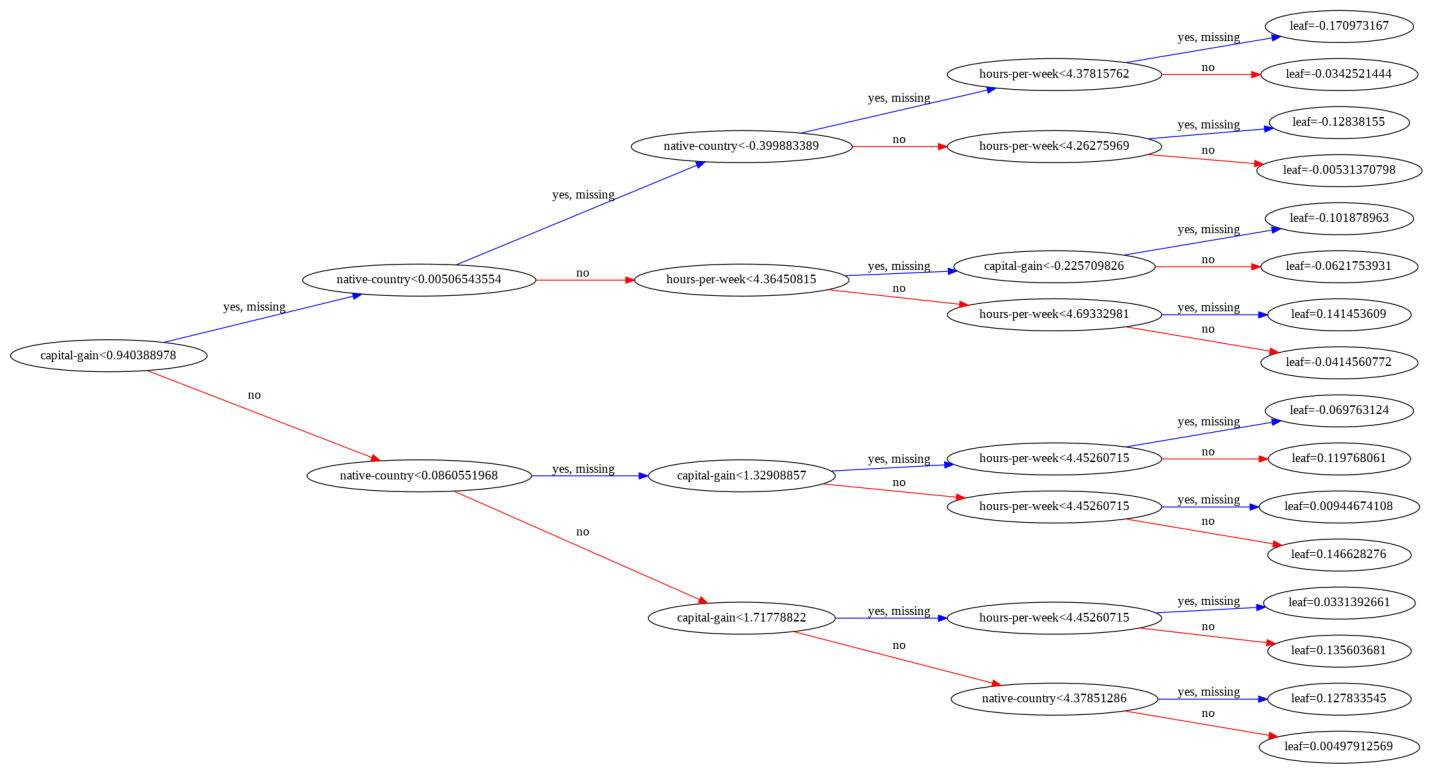

In [25]:
# Create the feature importances plot
fig, ax = plt.subplots(figsize=(20,20))
# plot a decision tree from the booster
plot_tree(booster=xgc, num_trees=1, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()